In [4]:
# install technical indicators and time series (ARCH, GARCH, metrics) supoort
!pip install pandas_ta --quiet
!pip install arch --quiet
!pip install statsmodels --quiet
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy statsmodels matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
from io import BytesIO        # For getting the daily policy df from download
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import warnings
from collections import Counter

# yahoo finance import
import yfinance as yf

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imputation and class rebalancing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# technical indicators
import pandas_ta as ta  # For technical indicators

# time series
from statsmodels.tsa.stattools import acf, pacf, adfuller # for time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm # for time series
from arch import arch_model # for time series

# RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV

# PCA and statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress convergence warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
# Load Kaggle dataset

# NOTE: First time use, ensure you have Kaggle API set up: https://github.com/Kaggle/kaggle-api
# Download manually if needed
# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone
# kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

KAGGLE_CSV_PATH = "stock_data.csv"  # Update path after download
os.environ['KAGGLE_USERNAME'] = "donaldkrapohl"
os.environ['KAGGLE_KEY'] = "c455129dcb3365a67517797f19ee384d"


# Download the dataset from Kaggle
!kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

# Unzip the downloaded file
!unzip -o 34-year-daily-stock-data.zip


Dataset URL: https://www.kaggle.com/datasets/shiveshprakash/34-year-daily-stock-data
License(s): MIT
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 995MB/s]
Archive:  34-year-daily-stock-data.zip
  inflating: stock_data.csv          


Columns
* dt: Date of observation in YYYY-MM-DD format.
* vix: VIX (Volatility Index), a measure of expected market volatility.
* sp500: S&P 500 index value, a benchmark of the U.S. stock market.
* sp500_volume: Daily trading volume for the S&P 500.
* djia: Dow Jones Industrial Average (DJIA), another key U.S. market index.
* djia_volume: Daily trading volume for the DJIA.
* hsi: Hang Seng Index, representing the Hong Kong stock market.
* ads: Aruoba-Diebold-Scotti (ADS) Business Conditions Index, reflecting U.S. economic activity.
* us3m: U.S. Treasury 3-month bond yield, a short-term interest rate proxy.
* joblessness: U.S. unemployment rate, reported as quartiles (1 represents lowest quartile and so on).
* epu: Economic Policy Uncertainty Index, quantifying policy-related economic uncertainty.
* GPRD: Geopolitical Risk Index (Daily), measuring geopolitical risk levels.
* prev_day: Previous day’s S&P 500 closing value, added for lag-based time series analysis.

In [7]:

# Check if the file exists before reading
if os.path.exists(KAGGLE_CSV_PATH):
    df = pd.read_csv(KAGGLE_CSV_PATH, parse_dates=['dt'])
    df.sort_values('dt', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={'dt': 'Date'}, inplace=True)  # rename to match OHLC
    print("Kaggle DataFrame loaded successfully.")
else:
    print(f"Error: {KAGGLE_CSV_PATH} not found.")

df.head(5)

Kaggle DataFrame loaded successfully.


,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [8]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day'],
      dtype='object')

In [9]:

# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone
# Download ohlc data (match the Kaggle coverage)
ohlc = yf.download("^GSPC", start="1990-01-01", end='2024-02-16', group_by="column")
ohlc.reset_index(inplace=True)  # Date becomes a column
ohlc.columns = [c[0] if isinstance(c, tuple) else c for c in ohlc.columns]                         # Make Date a column

# Rename to match your Kaggle naming style
ohlc.rename(columns={
    'Open':'sp500_open',
    'High':'sp500_high',
    'Low':'sp500_low',
    'Close':'sp500_close',
    'Adj Close':'sp500_adj_close',
    'Volume':'sp500_ohlc_volume'
}, inplace=True)

print(ohlc.head())


[*********************100%***********************]  1 of 1 completed

        Date  sp500_close  sp500_high   sp500_low  sp500_open  \
0 1990-01-02   359.690002  359.690002  351.980011  353.399994   
1 1990-01-03   358.760010  360.589996  357.890015  359.690002   
2 1990-01-04   355.670013  358.760010  352.890015  358.760010   
3 1990-01-05   352.200012  355.670013  351.350006  355.670013   
4 1990-01-08   353.790009  354.239990  350.540009  352.200012   

   sp500_ohlc_volume  
0          162070000  
1          192330000  
2          177000000  
3          158530000  
4          140110000  


In [10]:
ohlc.columns

Index(['Date', 'sp500_close', 'sp500_high', 'sp500_low', 'sp500_open',
       'sp500_ohlc_volume'],
      dtype='object')

Columns
* Date: trading date
* sp500_open: open price (USD)
* sp500_high: high price for the day
* sp500_low: low price for the day
* sp500_close: closing price for the day
* sp500_adj_close:
* sp500_ohlc_volume: day trading volume


I will add daily economic policy uncertainty index instead of the weekly value in the macroeconomic data

In [11]:

# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone

# Download and read CSV directly into a DataFrame
# These data are daily and built from term counts in major newspapers
#   specifically related to national policy uncertainty.
url = "https://www.policyuncertainty.com/media/All_Daily_Policy_Data.csv"
response = requests.get(url)
response.raise_for_status()   # ensure download succeeded

# Get into pandas df
df_epu = pd.read_csv(BytesIO(response.content), encoding="ISO-8859-1")

# Take the first three columns (day, month, year) and make a date
df_epu['Date'] = pd.to_datetime(dict(year=df_epu.iloc[:,2],
                                 month=df_epu.iloc[:,1],
                                 day=df_epu.iloc[:,0]),
                            errors='coerce')

# Keep only 'Date' and 'daily_policy_index'
# (the 4th column appears to be the daily policy index)
df_epu = df_epu[['Date', df_epu.columns[3]]].rename(columns={df_epu.columns[3]: 'daily_policy_index'})

# Convert daily_policy_index to numeric
df_epu['daily_policy_index'] = pd.to_numeric(df_epu['daily_policy_index'], errors='coerce')

# Drop rows with missing dates
df_epu = df_epu.dropna(subset=['Date'])

# Display the first few rows
df_epu.tail()


,Date,daily_policy_index
14903,2025-10-20,345.48
14904,2025-10-21,277.91
14905,2025-10-22,496.14
14906,2025-10-23,237.33
14907,2025-10-24,347.15


Merge the pricing, macroeconomics, and economic policy daily

In [12]:
# Ensure all are datetime and sorted
df['Date'] = pd.to_datetime(df['Date'])
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
df_epu['Date'] = pd.to_datetime(df_epu['Date'])

# Merge on Date
merged = pd.merge(df, df_epu, on='Date', how='left')  # put economic policy into df
merged = pd.merge(merged, ohlc, on='Date', how='left')    # and append pricing

print(merged.head())


        Date    vix       sp500  sp500_volume     djia  djia_volume  \
0 1990-01-03  18.19  358.760010   192330000.0  2809.73        23.62   
1 1990-01-04  19.22  355.670013   177000000.0  2796.08        24.37   
2 1990-01-05  20.11  352.200012   158530000.0  2773.25        20.29   
3 1990-01-08  20.26  353.790009   140110000.0  2794.37        16.61   
4 1990-01-09  22.20  349.619995   155210000.0  2766.00        15.80   

           hsi       ads  us3m  joblessness         epu        GPRD  \
0  2858.699951 -0.229917  7.89            3  100.359178   75.408051   
1  2868.000000 -0.246065  7.84            3  100.359178   56.085804   
2  2839.899902 -0.260393  7.79            3  100.359178   63.847675   
3  2816.000000 -0.291750  7.79            3  100.359178  102.841156   
4  2822.000000 -0.297326  7.80            3  100.359178  138.435669   

     prev_day  daily_policy_index  sp500_close  sp500_high   sp500_low  \
0  359.690002               59.10   358.760010  360.589996  357.890015  

In [13]:
merged.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume'],
      dtype='object')

In [14]:
# Calculate and display descriptive statistics for the numerical columns
display(merged.describe(percentiles=[0.5]))

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,daily_policy_index,sp500_close,sp500_high,sp500_low,sp500_open,sp500_ohlc_volume
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8596.000000,8596.000000,8596.000000,8596.000000,8.596000e+03
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,115.564631,109.435667,1596.111831,105.671574,1596.255668,1605.315556,1585.878406,1595.898788,2.464575e+09
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,57.202620,9.491598,295.459991,3.320000,295.459991,301.450012,294.510010,295.450012,0.000000e+00
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,106.115769,96.603577,1270.089966,85.790000,1270.144958,1277.485046,1261.724976,1270.040039,2.518410e+09
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,350.459817,1045.603638,5029.730000,1026.380000,5029.729980,5048.390137,5016.830078,5026.830078,1.145623e+10
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,41.579530,64.568210,1105.710429,77.461526,1105.694314,1111.322169,1099.282548,1105.438383,1.848602e+09


In [15]:
# make the response variables we'll likely build models over later
# this is the 5 and 20 day returns
merged['5d_return'] = (merged['sp500_close'] - merged['sp500_close'].shift(5))
merged['20d_return'] = (merged['sp500_close'] - merged['sp500_close'].shift(20))


In [16]:
# add 1, 5, 20 day price direction
merged['1d_return'] = merged['sp500_close'].pct_change()  # (today - yesterday)/yesterday

# Use returns (daily pct change) and scale
merged['1d_return_pct'] = merged['1d_return'] * 100

# 1-day direction: +1 if up, -1 if down
merged['direction_1d'] = np.where(merged['1d_return'].shift(-1) >0, 1, -1)

# 5-day direction: sum returns over next 5 days, then take sign
merged['direction_5d'] = np.where(merged['1d_return'].rolling(5).sum().shift(-5) >0, 1,-1)

# 20-day direction: sum returns over next 20 days, then take sign
merged['direction_20d'] = np.where(merged['1d_return'].rolling(20).sum().shift(-20) >0, 1, -1)



In [17]:
# add technical indicators

# -------------------------- MOMENTUM ---------------------------
# MACD
macd = ta.macd(merged['sp500_close'])
merged['macd'] = macd['MACD_12_26_9']
merged['macd_signal'] = macd['MACDs_12_26_9']

# Rate of change (ROC))
merged['roc'] = ta.momentum.roc(close=merged['sp500_close'])

# relative strength (RSI)
merged['rsi'] = ta.rsi(merged['sp500_close'], length=14)

# Fast and slow stochastic
df_stoch = ta.stoch(merged['sp500_high'],merged['sp500_low'],merged['sp500_close'], k=14, d=3)
merged['stoch_k'] = df_stoch['STOCHk_14_3_3']
merged['stoch_d'] = df_stoch['STOCHd_14_3_3']

# Average Directional Movement (ADX)
merged['adx'] = ta.adx(merged['sp500_high'], merged['sp500_low'], merged['sp500_close'], timeperiod=14)['ADX_14']

# -------------------- Volume ------------------------------------
# On-Balance Volume (OBV)
merged['obv'] = ta.volume.obv(close=merged['sp500_close'], volume=merged['sp500_ohlc_volume'])

# ------------------ Volatility ----------------------------------
# Average True Range (ATR)
merged['atr'] = ta.volatility.atr(high=merged['sp500_high'], low=merged['sp500_low'], close=merged['sp500_close'], window=14)

# Bollinger Bands
bb = ta.bbands(merged['sp500_close'], length=20)
merged['bb_upper'] = bb['BBU_20_2.0_2.0']
merged['bb_middle'] = bb['BBM_20_2.0_2.0']
merged['bb_lower'] = bb['BBL_20_2.0_2.0']

# ------------------- Moving averages ---------------------------
# Exponential Moving Average (EMA)

merged['ema_12'] = merged['sp500_close'].ewm(span=12, adjust=False).mean()
merged['ema_26'] = merged['sp500_close'].ewm(span=26, adjust=False).mean()

# Simple Moving Average (SMA)
merged['sma_5'] = merged['sp500_close'].rolling(window=5).mean()
merged['sma_20'] = merged['sp500_close'].rolling(window=20).mean()


In [18]:
df=merged
df.head(2)

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,adx,obv,atr,bb_upper,bb_middle,bb_lower,ema_12,ema_26,sma_5,sma_20
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,...,NaN,NaN,NaN,NaN,NaN,NaN,358.760010,358.760010,NaN,NaN
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,...,NaN,-177000000.0,NaN,NaN,NaN,NaN,358.284626,358.531121,NaN,NaN


Clean up any remaining missing dates. Delete instead of imputing.

In [19]:
def print_missing_value_counts(df):
  # Count NaNs in any column
  print(df.isna().any(axis=1).sum())

print_missing_value_counts(df)

# drop rows with ANY NaN values
df = df.dropna()

# reset the index to clean up
df = df.reset_index(drop=True)

# verify
print_missing_value_counts(df)

34
0


## Basic time series to select lags

### Test stationarity

In [20]:
# Drop missing values
close_no_na = df['sp500_close'].dropna()

# Remove trend to get stationarity (first difference)
close_first_diff = close_no_na.diff().dropna()

# do ADF test for stationarity
adf_result = adfuller(close_first_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

if adf_result[1] < 0.05:
    print("Series is likely stationary")
else:
    print("Series is likely non-stationary")

ADF Statistic: -16.111610876212875
p-value: 5.006114027981422e-29
Critical Value (1%): -3.4311173044135175
Critical Value (5%): -2.8618790964466667
Critical Value (10%): -2.5669504961292042
Series is likely stationary


### Train OLS Model and plot the ACF/PACF

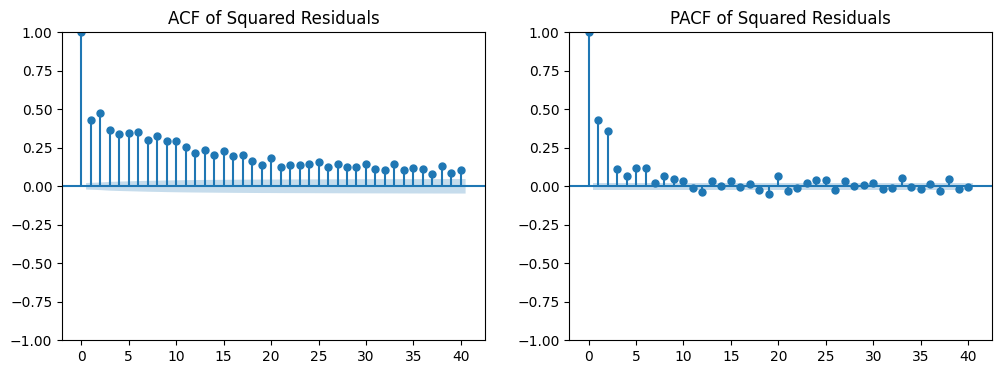

In [21]:
# fit basic regression (OLS)
X = sm.add_constant(np.ones(len(close_first_diff)))
ols_model = sm.OLS(close_first_diff.values, X).fit()
squared_resid = ols_model.resid**2  # need squared residuals for ACF/PACF

# Plot ACF and PACF of squared residuals
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(squared_resid, lags=40, ax=plt.gca())
plt.title('ACF of Squared Residuals')

plt.subplot(1,2,2)
plot_pacf(squared_resid, lags=40, ax=plt.gca())
plt.title('PACF of Squared Residuals')
plt.show()

In [22]:

# ARCH lag selection
max_lag = 20
aic_list, bic_list = [], []

for p in range(1, max_lag + 1):
    am = arch_model(close_first_diff, vol='ARCH', p=p, o=0, q=0, dist='normal', rescale=True)
    res = am.fit(disp='off')
    aic_list.append(res.aic)
    bic_list.append(res.bic)

# Compile results
arch_lag_selection = pd.DataFrame({
    'lag': range(1, max_lag + 1),
    'AIC': aic_list,
    'BIC': bic_list
})

# Display table
print(arch_lag_selection)

# Optimal lag
optimal_lag_aic = arch_lag_selection.loc[arch_lag_selection['AIC'].idxmin(), 'lag']
optimal_lag_bic = arch_lag_selection.loc[arch_lag_selection['BIC'].idxmin(), 'lag']
print(f"Best ARCH lag (AIC): {optimal_lag_aic}")
print(f"Best ARCH lag (BIC): {optimal_lag_bic}")

    lag           AIC           BIC
0     1  73240.123901  73261.289169
1     2  70690.899804  70719.120160
2     3  69375.070108  69410.345553
3     4  68567.483050  68609.813584
4     5  68058.894388  68108.280012
5     6  67813.185777  67869.626489
6     7  67585.584037  67649.079839
7     8  67306.847904  67377.398795
8     9  67105.541850  67183.147830
9    10  67015.424855  67100.085924
10   11  66939.355470  67031.071628
11   12  66913.735188  67012.506435
12   13  66878.841268  66984.667605
13   14  66845.818958  66958.700384
14   15  66831.270210  66951.206725
15   16  66774.146063  66901.137667
16   17  66737.969428  66872.016121
17   18  66727.998635  66869.100417
18   19  66681.752201  66829.909072
19   20  66672.143355  66827.355314
Best ARCH lag (AIC): 20
Best ARCH lag (BIC): 20


/tmp/ipython-input-1132820473.py:7: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


ARCH model specified lag at max lag, which is too high. Move would move to GARCH(1,1) but we'll just use the EMA and SMA indicators already in the features.

In [23]:
# make a 1 day lag like a VAR model
df[f'return_lag_1'] = df['1d_return'].shift(1) # acf+pacf said 1 day lag is potenntially relevant

# Add to potentially overcome clustering of volatility metrics
df['roll_std_5'] = df['1d_return'].rolling(5).std()
df['roll_std_20'] = df['1d_return'].rolling(20).std()


In [24]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume', '5d_return', '20d_return',
       '1d_return', '1d_return_pct', 'direction_1d', 'direction_5d',
       'direction_20d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_5', 'sma_20', 'return_lag_1', 'roll_std_5',
       'roll_std_20'],
      dtype='object')

AIC and BIC indicate the lag of 1 is most useful but the values drop off quickly potentially indicating volatility is making ARCH model lag less useful. We'll select return at lag=1 as an additional feature.

## Generate descriptive statistics

Calculate and display descriptive statistics for the numerical columns in the DataFrame.


In [25]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume', '5d_return', '20d_return',
       '1d_return', '1d_return_pct', 'direction_1d', 'direction_5d',
       'direction_20d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_5', 'sma_20', 'return_lag_1', 'roll_std_5',
       'roll_std_20'],
      dtype='object')

In [26]:
display(df.describe())

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,bb_upper,bb_middle,bb_lower,ema_12,ema_26,sma_5,sma_20,return_lag_1,roll_std_5,roll_std_20
count,8563,8563.000000,8563.000000,8.563000e+03,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,...,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8562.000000,8559.000000,8544.000000
mean,2007-02-11 14:57:29.912413952,19.545540,1601.110797,2.472477e+09,13702.038018,183.783528,16817.268997,-0.158804,2.669737,2.490599,...,1647.993998,1595.966088,1543.938179,1598.130919,1594.437356,1600.019629,1595.966088,0.000382,0.009273,0.009756
min,1990-02-20 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2760.000000,-26.418300,0.000000,1.000000,...,317.280394,305.832503,294.092668,303.711152,308.216878,299.280005,305.832503,-0.119841,0.000530,0.002072
25%,1998-08-08 12:00:00,13.840000,903.739990,6.627500e+08,8088.595000,65.420000,10764.159668,-0.384565,0.180000,1.000000,...,945.786727,901.241003,853.721526,900.935014,901.422658,901.565009,901.241003,-0.004477,0.004996,0.006028
50%,2007-02-13 00:00:00,17.700000,1272.069946,2.542000e+09,10858.250000,178.620000,16892.929688,-0.045867,2.250000,2.000000,...,1309.090562,1271.783014,1234.635731,1272.093877,1271.219907,1271.657983,1271.783014,0.000575,0.007554,0.008274
75%,2015-08-13 12:00:00,22.910000,2061.140014,3.836725e+09,17661.825000,272.790000,22885.080078,0.247743,4.975000,3.000000,...,2113.815784,2055.882510,2004.945390,2058.459767,2052.351482,2060.511987,2055.882510,0.005721,0.011377,0.011716
max,2024-02-15 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,...,5064.318909,4934.692529,4807.993407,4971.622114,4906.537515,5006.393945,4934.692529,0.115800,0.094495,0.061182
std,NaN,7.913029,1105.047817,1.845382e+09,9010.774431,133.548515,7313.379817,1.654611,2.277407,1.119156,...,1137.132272,1099.531156,1063.360277,1101.660069,1097.710254,1103.834092,1099.531156,0.011437,0.007061,0.006127


## Explore correlations

Calculate and visualize the correlation matrix to understand the relationships between different features.


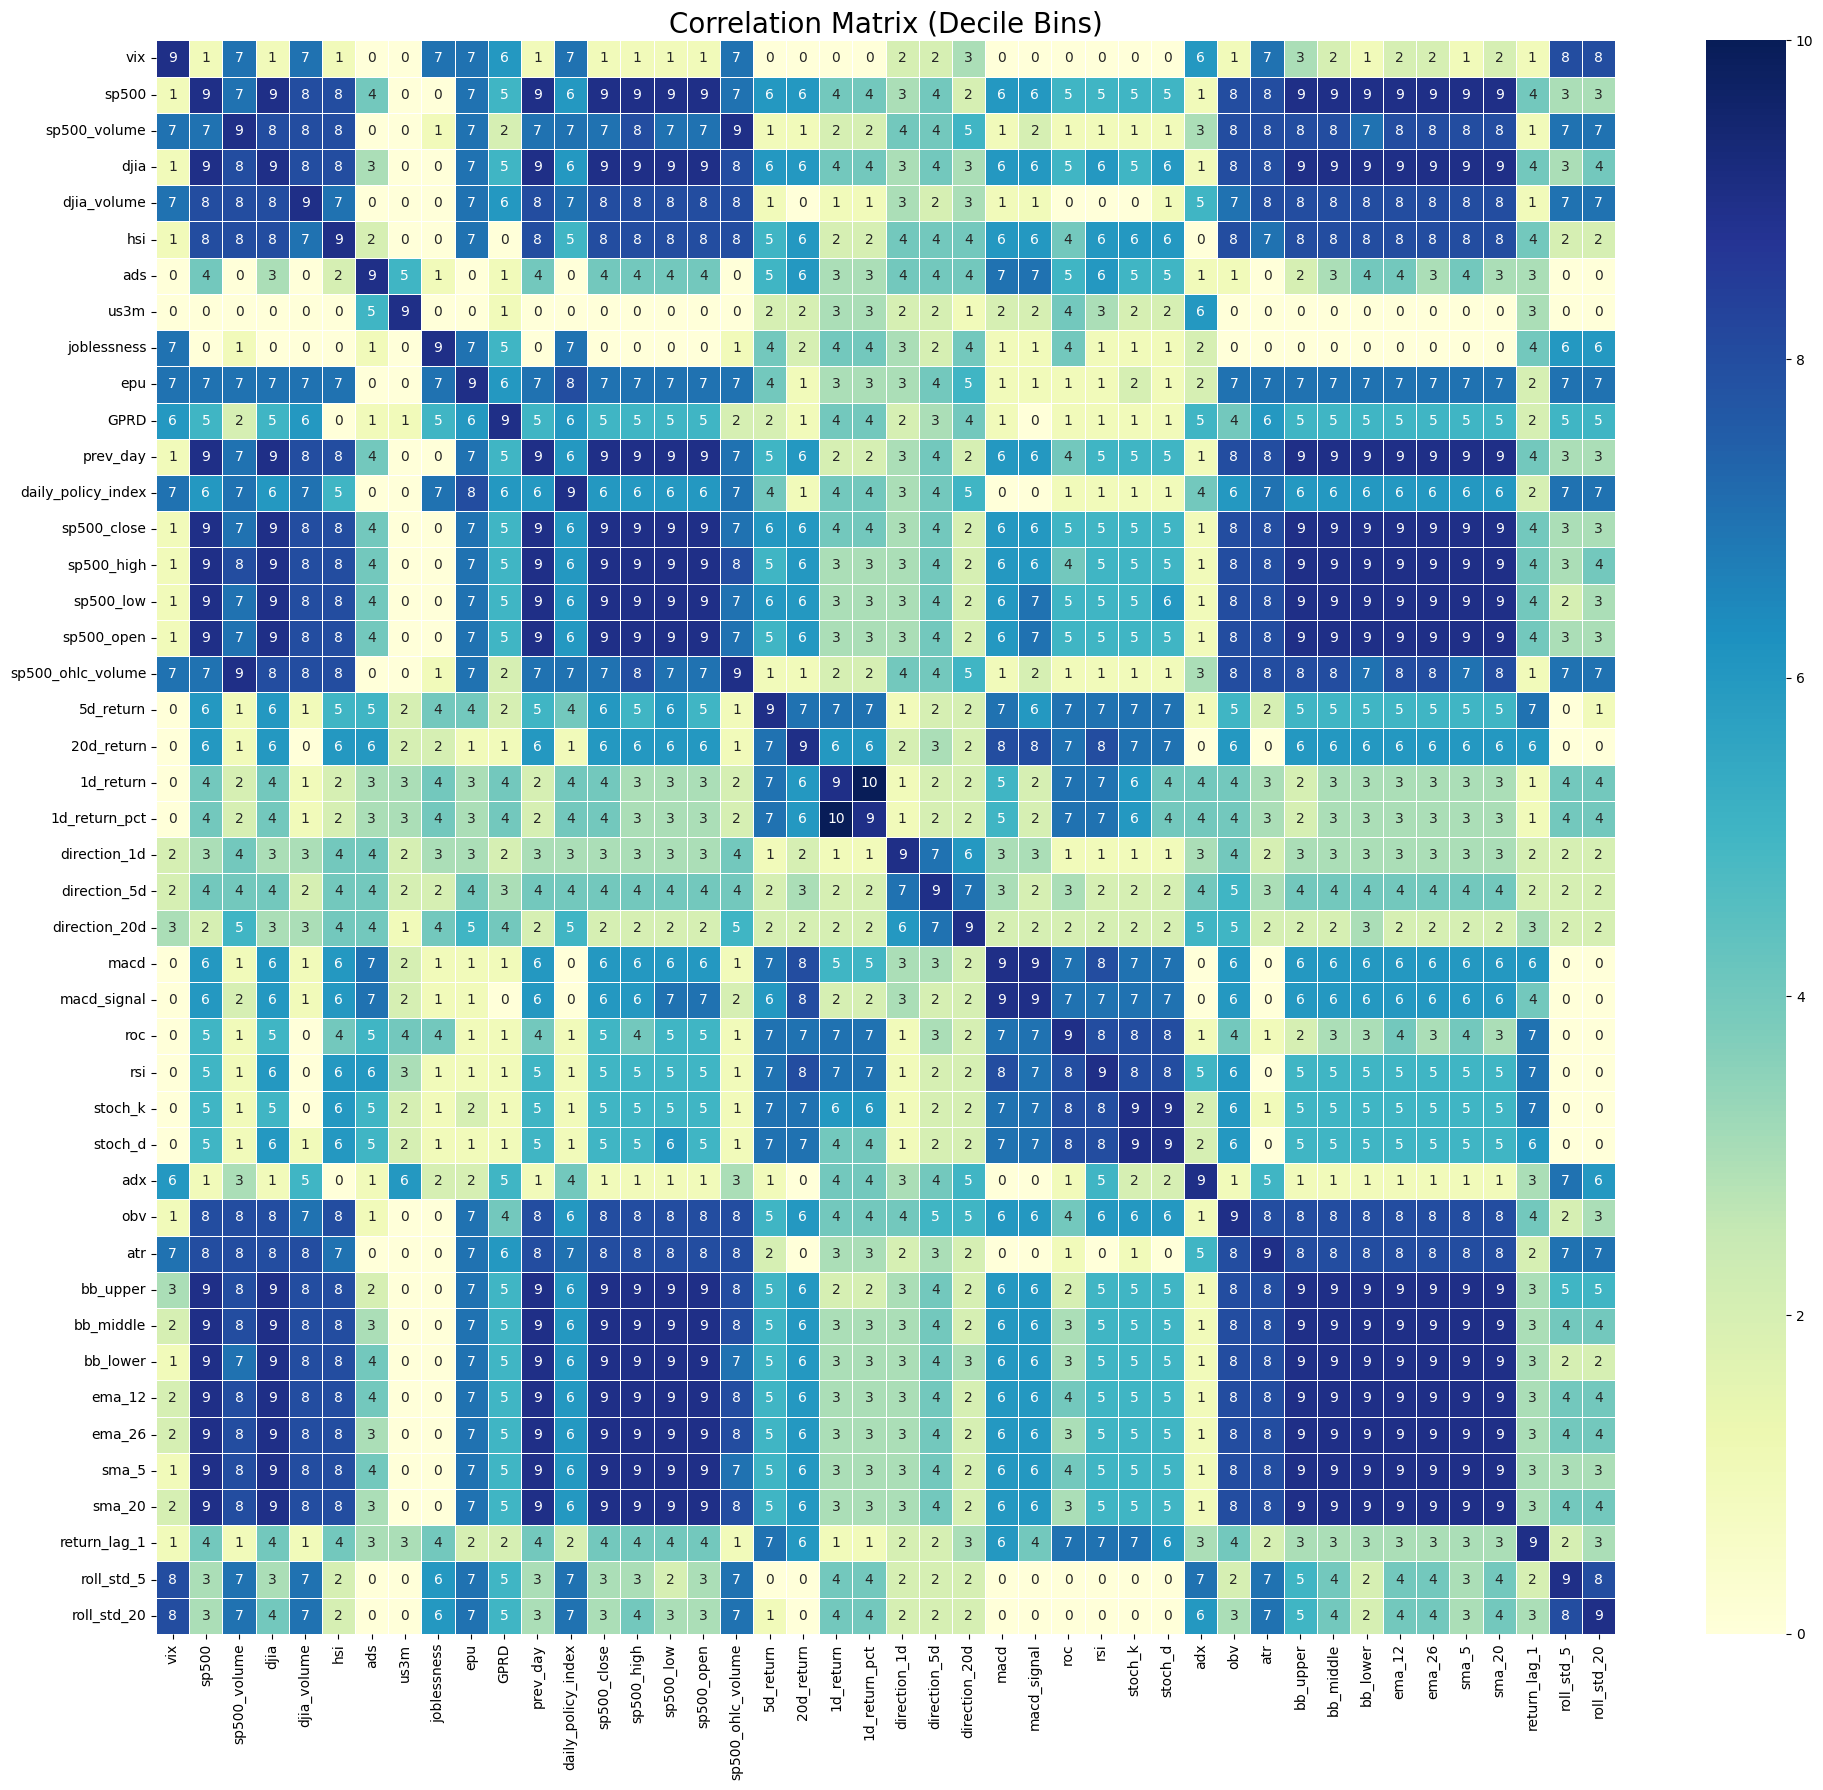

In [27]:
# get the decile for each correlation to give 0-10 heat map/correlation matrix
def assign_decile(x):
    return np.searchsorted(deciles, x, side="right") - 1


# Compute correlation matrix (numeric only)
corr_matrix = df.corr(numeric_only=True)

# Flatten and compute deciles
corr_values = corr_matrix.to_numpy().flatten()        # get the matrix to a numpy array
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)      # create the identify matrix
deciles = np.percentile(corr_values[mask.flatten()], np.arange(0, 101, 10)) # get percentiles

corr_decile = corr_matrix.applymap(assign_decile)     # get the deciles

# make the heatmap of deciles
plt.figure(figsize=(20, 18))  # make figure larger
sns.heatmap(
    corr_decile,
    annot=True,
    fmt="d",
    cmap="YlGnBu",  # use yellow-green-blue since I'm colorblind
    cbar=True,
    linewidths=0.5, # add grid lines between cells
)

plt.title("Correlation Matrix (Decile Bins)", fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


## Visualize target variable distribution

Visualize the distribution of the target variables (1-day, 5-day, and 20-day directions) to understand the class balance.


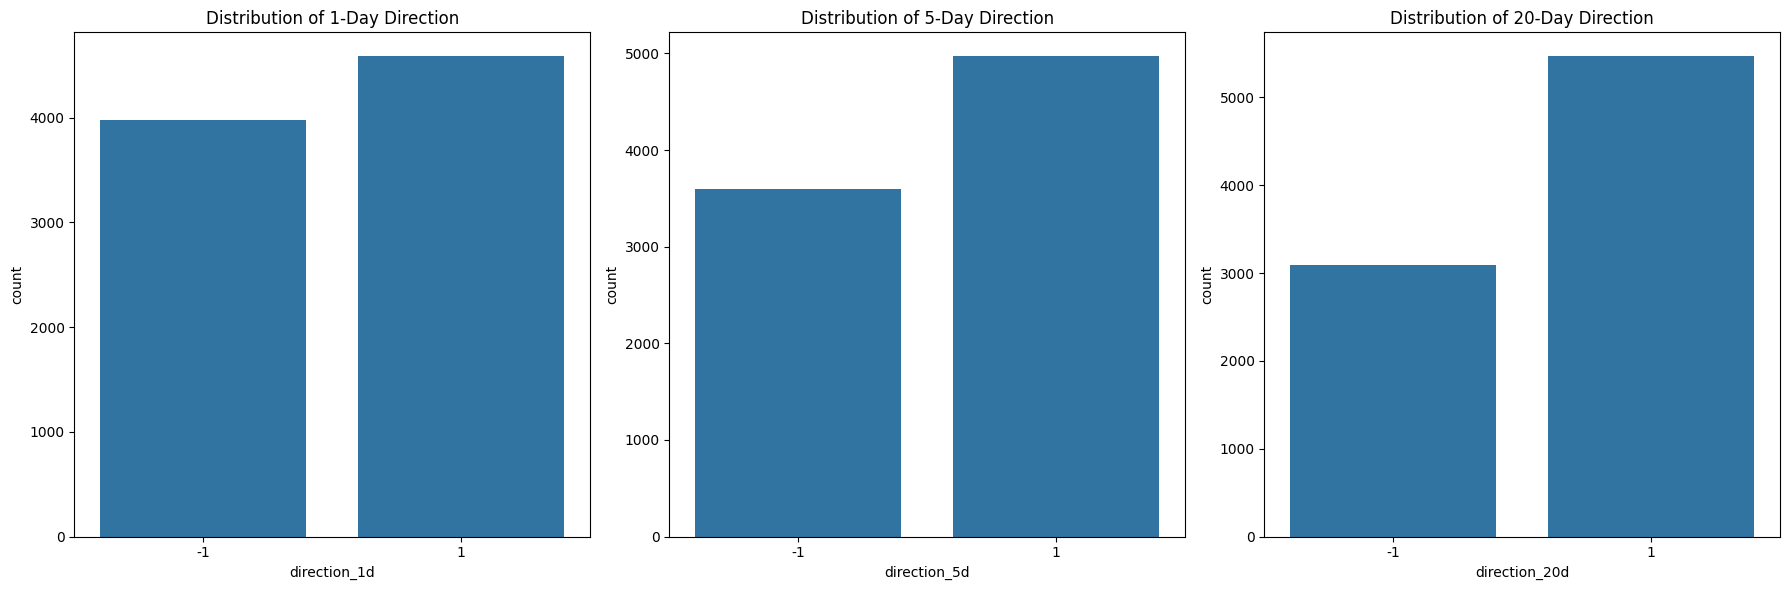

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='direction_1d', data=df, ax=axes[0])
axes[0].set_title('Distribution of 1-Day Direction')

sns.countplot(x='direction_5d', data=df, ax=axes[1])
axes[1].set_title('Distribution of 5-Day Direction')

sns.countplot(x='direction_20d', data=df, ax=axes[2])
axes[2].set_title('Distribution of 20-Day Direction')

plt.tight_layout()
plt.show()

I'll record the 1, 5, and 20 day class imbalance

Last round before we train, we've added rolling data so we'll do a mean imputer for the periods we don't have. We'll be missing 19 values in the 20-day rolling column, 5 rows in the 5-day rolling, and 1 value in the lagged return column. We'll impute those in place.

In [29]:

# Get the count of missing values. Should be ~25
print_missing_value_counts(df)

# Columns to impute
cols_to_impute = ['return_lag_1', 'roll_std_5', 'roll_std_20']

# Initialize imputer to replace missing with the mean
imputer = SimpleImputer(strategy='mean')

# Fit on the missing values and transform
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Verify we're not missing any more
print_missing_value_counts(df)

19
0


In [30]:
# Prepare x and y for modeling
# Separate features and target
predictor_drop_columns = ['direction_1d', 'direction_5d', 'direction_20d',
                     'Date', '1d_return', '1d_return_pct', 'return_lag_1',
                     '5d_return', '20d_return',
                     'sp500', 'sp500_close']
df_input_features = df.drop(columns=predictor_drop_columns)   # predict the next day
y_basic_target = df['direction_1d']

## Define a modelling function
I will reuse a modelling function throughout my analysis to see how different transforms like PCA and column removal based on VIF change the model quality score.

In [42]:
# Function clean_params
# Purpose:
#   cleans the data type info from the params collection for printout
# Parameters:
#   params - dictionary of parameters in the random forest model
# Output:
#   dictionary with the data type names removed
def clean_params(params):
    """Convert NumPy types in params to plain Python types for clean printing."""
    def convert(v):
        if isinstance(v, (np.integer,)):
            return int(v)
        elif isinstance(v, (np.floating,)):
            return float(v)
        elif isinstance(v, (np.str_,)):
            return str(v)
        return v
    return {k: convert(v) for k, v in params.items()}

# Function do_train_rf
# Purpose:
#   Train a random forest model with random search for hyperparameter tuning
#   Report on the out-of-bag score for each randomly trained model
#   Preserve the best model for use
# Parameters:
#   X - the set of predictor features
#   y - the target feature
#   {n_models} - optional, number of models to train in the search
# Output: trained random forest model using best hyperparameters

def do_train_rf(X, y, n_models=5):
  # Define random search space
  param_space = {
      'n_estimators': np.arange(100, 500, 50),
      'max_depth': np.arange(3, 20),
      'min_samples_split': np.arange(2, 20),
      'min_samples_leaf': np.arange(1, 20),
      'max_features': ['sqrt', 'log2']
  }

  best_score = -999999    # track our best OOB score
  best_hyperparams = None # collect the best hyperparameters
  best_rf_model = None    # keep the best for later "best features" review

  for i in range(n_models):
      # Randomly sample parameters
      params = {
          'n_estimators': np.random.choice(param_space['n_estimators']),
          'max_depth': np.random.choice(param_space['max_depth']),
          'min_samples_split': np.random.choice(param_space['min_samples_split']),
          'min_samples_leaf': np.random.choice(param_space['min_samples_leaf']),
          'max_features': np.random.choice(param_space['max_features']),
          'bootstrap': True,
          'oob_score': True,
          'random_state': 17
      }

      # Train model
      rf_model = RandomForestClassifier(**params)
      rf_model.fit(X, y)

      # Compute OOB accuracy and print for each round
      oob_acc = rf_model.oob_score_
      print(f"Round {i+1}: OOB Accuracy = {oob_acc:.4f}, Params = {clean_params(params)}")

      # Track best
      if oob_acc > best_score:
          best_score = oob_acc
          best_params = params
          best_model = rf_model

  # Print best OOB score and parameters

  print("Best OOB Score:", best_score)
  print("Best Parameters:", clean_params(best_params)

  # return the best model
  return best_model



SyntaxError: '(' was never closed (ipython-input-2328023336.py, line 75)

### Initial Training, Setup for Feature Reduction
I will now train using a 50-round iteration to train an initial model. The outputs of this will be used to guage the first approximation of a good model and the feature importances will be used for further input feature reduction.

In [41]:

# Call the reusable function asking for 50 iterations of search
best_rf_model = do_train_rf(df_input_features, y_basic_target, n_models =50 )

Round 1: OOB Accuracy = 0.8283, Params = {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Best OOB Score: 0.8283311923391334
Best Parameters: {'n_estimators': np.int64(450), 'max_depth': np.int64(10), 'min_samples_split': np.int64(16), 'min_samples_leaf': np.int64(2), 'max_features': np.str_('sqrt'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}


These scores were better than average. I'll compute the Variance Inflation Factor (VIF) to see if there is any standout multicollinearity in the features.

In [33]:
# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = df_input_features.columns    # get column list

# For each factor, compute the VIF
vif_data['VIF'] = [variance_inflation_factor(df_input_features.values, i) for i in range(df_input_features.shape[1])]

# Sort by VIF descending. I want the most collinear first
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

               feature           VIF
31              sma_20           inf
26           bb_middle           inf
25            bb_upper  9.007199e+15
27            bb_lower  4.503600e+15
28              ema_12  1.021109e+10
29              ema_26  1.013942e+10
16                macd  3.916514e+06
30               sma_5  9.649410e+04
14          sp500_open  4.829577e+04
12          sp500_high  3.000761e+04
10            prev_day  2.481915e+04
13           sp500_low  2.143973e+04
15   sp500_ohlc_volume  1.958218e+03
1         sp500_volume  1.952108e+03
17         macd_signal  4.615025e+02
2                 djia  2.633078e+02
23                 obv  5.964816e+01
20             stoch_k  2.189405e+01
21             stoch_d  1.955585e+01
24                 atr  1.887961e+01
33         roll_std_20  1.100719e+01
0                  vix  7.622268e+00
4                  hsi  5.653729e+00
3          djia_volume  5.083330e+00
32          roll_std_5  4.484181e+00
8                  epu  3.960457e+00
1

I'll drop anything with VIF higher than 10 to remove highly collinear columns

In [34]:
# I'm setting the VIF threshold here. Typical values are 5 or 10.
vif_threshold = 10

# Prep
vif_data = pd.DataFrame()         # new df to receive vif
vif_data['feature'] = df_input_features.columns   # get the feature names for print later

# Compute VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(df_input_features.values, i) for i in range(df_input_features.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)   # Sort the df

# List features to drop
features_to_drop = vif_data[vif_data['VIF'] > vif_threshold]['feature'].tolist()

print("High multicollinearity (VIF > {}):".format(vif_threshold))
print(features_to_drop)

High multicollinearity (VIF > 10):
['sma_20', 'bb_middle', 'bb_upper', 'bb_lower', 'ema_12', 'ema_26', 'macd', 'sma_5', 'sp500_open', 'sp500_high', 'prev_day', 'sp500_low', 'sp500_ohlc_volume', 'sp500_volume', 'macd_signal', 'djia', 'obv', 'stoch_k', 'stoch_d', 'atr', 'roll_std_20']


In [35]:
# now drop them
df_no_multicollinearity = df_input_features.drop(columns=features_to_drop)

# Train a model now without those features and measure
best_rf_model = do_train_rf(df_no_multicollinearity, y_basic_target, n_models=50)

Round 1: OOB Accuracy = 0.5316, Params = {'n_estimators': np.int64(300), 'max_depth': np.int64(5), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(16), 'max_features': np.str_('log2'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.5095, Params = {'n_estimators': np.int64(150), 'max_depth': np.int64(19), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(5), 'max_features': np.str_('sqrt'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.5239, Params = {'n_estimators': np.int64(400), 'max_depth': np.int64(14), 'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(9), 'max_features': np.str_('log2'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5331, Params = {'n_estimators': np.int64(350), 'max_depth': np.int64(4), 'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(18), 'max_features': np.str_('log2'), 'bootstrap': True, 'oob_

My scores have not improved through multicollinear feature removal. Try PCA to see if that helps.

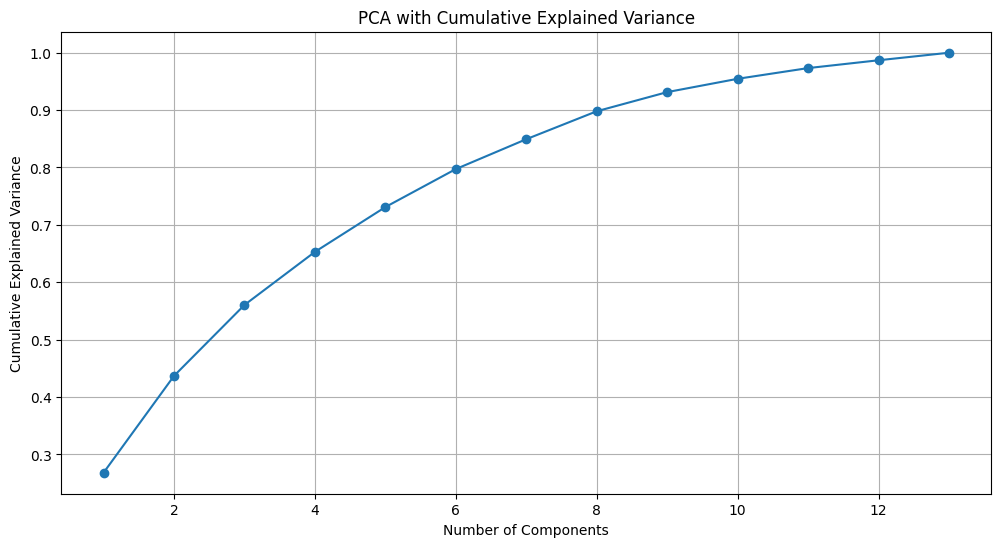

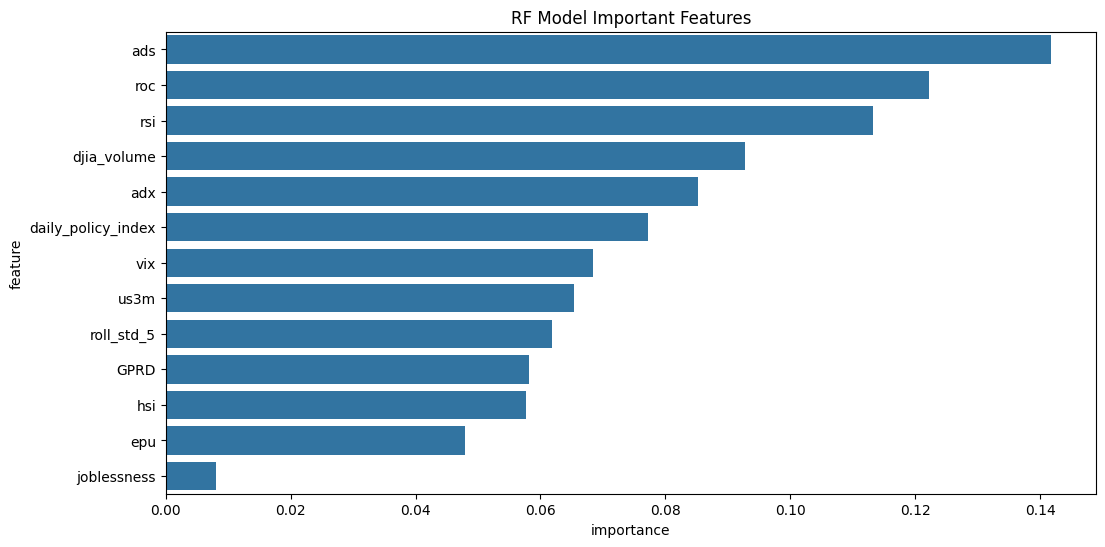

In [36]:

# Going to do PCA to analyze features
# Scale the features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_multicollinearity)

# Apply PCA
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_scaled)

# Create a cumulative plot of the explained_variance_ratio_ values from PCA
explained_var_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_var_ratio)+1), np.cumsum(explained_var_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA with Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Create a plot fo the most important features
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': df_no_multicollinearity.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('RF Model Important Features')
plt.show()

# I'll get the number of features that add up to 90% of the variability
#   then I'll use those to set the reduced feature set later after PCA
# Have to add 1 to ensure we capture 90 and never choose zero features
ideal_number_features = (np.cumsum(explained_var_ratio) >= 0.90).argmax() + 1


I will now make a set with only the features that collectively explain >90% of the model variance.

In [37]:

# We previously set ideal number of features in a variable in PCA.
# Use it now

# Now get the list of features I will keep
# Get feature importances and their names
feature_importances = best_rf_model.feature_importances_  # importance values
feature_names = best_rf_model.feature_names_in_           # feature names

# Sort features by importance descending
sorted_importance = np.argsort(feature_importances)[::-1]

# Limit to ideal_number_features
top_features = sorted_importance[:ideal_number_features]

# Get feature names into list
features_to_preserve = feature_names[top_features]

print(f"Features to preserve: {features_to_preserve}")

# Make reduced set of features and train new model
X_feature_reduced = df_input_features[features_to_preserve]

# reuse our RF model training function
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=50)

Features to preserve: ['ads' 'roc' 'rsi' 'djia_volume' 'adx' 'daily_policy_index' 'vix' 'us3m'
 'roll_std_5']
Round 1: OOB Accuracy = 0.5246, Params = {'n_estimators': np.int64(100), 'max_depth': np.int64(19), 'min_samples_split': np.int64(17), 'min_samples_leaf': np.int64(2), 'max_features': np.str_('sqrt'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.5281, Params = {'n_estimators': np.int64(300), 'max_depth': np.int64(16), 'min_samples_split': np.int64(11), 'min_samples_leaf': np.int64(17), 'max_features': np.str_('sqrt'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.5262, Params = {'n_estimators': np.int64(300), 'max_depth': np.int64(11), 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(12), 'max_features': np.str_('sqrt'), 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5203, Params = {'n_estimators': np.int64(100), 'max_depth': np.int64(19), 'min_sample

No improvement. I will try 5-day and 20-day predictions to see if they are better.

In [50]:
y_basic_target = df['direction_5d']
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=5)

y_basic_target = df['direction_20d']
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=5)

Round 1: OOB Accuracy = 0.5808, Params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.6284, Params = {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.6101, Params = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5830, Params = {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.6523, Params = {'n_estimators': 350, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap

# Class balancing
Our 1, 5, and 20 day up and down indicator bar charts above indicated that we have more samples in the "up" direction with the imbalance increasing over time. I will improve the 20-day with SMOTE to resample and rebalance the classes then train and test a new  model.

In [53]:
smote = SMOTE(random_state=17)                        # init
X_balanced, y_balanced = smote.fit_resample(X_feature_reduced, y_basic_target)

rf_model = do_train_rf(X_balanced, y_balanced, n_models=5)

Round 1: OOB Accuracy = 0.8151, Params = {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.8650, Params = {'n_estimators': 300, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.8677, Params = {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.7925, Params = {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.7153, Params = {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstra

The 20-day class counts for the S&P500 being up or down

In [54]:

counts = Counter(y_basic_target)
print("Class counts for 20-day pricing being up or down")
print(f"Up (1): {counts.get(1, 0)} | Down (-1): {counts.get(-1, 0)}")

Class counts for 20-day pricing being up or down
Up (1): 5467 | Down (-1): 3096


# Predict Dataframe Requirements
We only need a subset of variables to do prediction. The columns must match the model.

In [55]:
X_balanced.columns

Index(['ads', 'roc', 'rsi', 'djia_volume', 'adx', 'daily_policy_index', 'vix',
       'us3m', 'roll_std_5'],
      dtype='object')

# Prediction
Code a method that will be used to predict the class 20 days in the future and the probability of that prediction.

In [46]:

# Function do_predict
# Purpose:
#   use the best trained model to do prediction
# Parameters:
#   model - model to use for prediction
#   df_input_features - dataframe with features to use to predict the outcome for input data
def do_predict(model, df_input_features):
  y_pred = model.predict(df_input_features)        # class
  y_prob = model.predict_proba(df_input_features)  # probability
  return y_pred, y_prob